In [2]:
# Packages importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(10,6))
import seaborn as sns

In [3]:
def clean_mun(df_orig, obce) -> pd.DataFrame:
    """
    Clean and prepare a dataframe containing data from local elections. The cleaning includes:
        -[cele_jmeno]: Combining name columns into one
        -[vs_vzdelani]: Creating a boolean column checking whether a candidate has university degree
        -[POVOLANI]: canidate's profession
        -[pohlavi]: candidate's gender (based on their surname's ending)
        -[pohlavi_encoded]: encoded genders
        -[kraj]: region where candidate runs their campaign
        -[kraj_encoded]: encoded regions
        -[OSTRANA]: political party
        -[POCPROVSE]: percentage of votes at the election

    :param df_orig: dataframe containing data from local elections
    :param obce: a dictionary containing regions' codes
    :return: dataframe with cleaned and encoded data
    """
    df = df_orig.copy()
    df["cele_jmeno"] = df["JMENO"] + " " + df["PRIJMENI"]
    df["pohlavi"] = np.where(df.loc[:, "cele_jmeno"].str[-1] == "á", "F", "M")
    df["vs_vzdelani"] = np.where((df["TITULPRED"].notnull()) | (df["TITULZA"].notnull()), 1, 0)
    df["kraj"] = df["KODZASTUP"].map(obce)

    kraj_dict = dict(zip(df[df["kraj"].notna()]["kraj"].unique(), list(range(1, 15))))
    kraj_dict["nan"] = 0
    pohlavi_dict = dict(zip(df["pohlavi"].unique(), list(range(2))))

    df["kraj_encoded"] = df["kraj"].map(kraj_dict)
    df["pohlavi_encoded"] = df["pohlavi"].map(pohlavi_dict)

    columns = ["cele_jmeno", "VEK", "vs_vzdelani", "POVOLANI", "pohlavi","pohlavi_encoded", "kraj", "kraj_encoded", "OSTRANA", "POCPROCVSE"]

    return df[columns]

In [4]:
zaso_list = []
zaso_years = [2006, 2010, 2014, 2018, 2022]

for year in zaso_years:
    temp_df = pd.read_csv(f"https://raw.githubusercontent.com/rmnskb/cz-elections/main/municipal-elections/zaso_{year}.csv", sep=";", encoding="utf-8")
    zaso_list.append(temp_df)

zaso_list[0].head()

,OKRES,KODZASTUP,COBVODU,POR_STR_HL,OSTRANA,PORCISLO,JMENO,PRIJMENI,TITULPRED,TITULZA,...,NSTRANA,PLATNOST,POCHLASU,POCHL_PRES,POCPROCVSE,MANDAT,PORADIMAND,PORADINAHR,POHLAVI,DATNAR
0,7204,500011,1,1,166,1,Michal,Špendlík,NaN,NaN,...,166,0,951.0,951.0,"14,15",1.0,1,0,NaN,NaN
1,7204,500011,1,1,166,2,Hana,Svobodová,Ing.,NaN,...,166,0,890.0,890.0,"13,24",1.0,2,0,NaN,NaN
2,7204,500011,1,1,166,3,Jaromír,Macík,PaedDr.,NaN,...,166,0,813.0,813.0,"12,1",1.0,3,0,NaN,NaN
3,7204,500011,1,1,166,4,Pavla,Paprčková,JUDr.,NaN,...,166,0,802.0,802.0,"11,93",1.0,4,0,NaN,NaN
4,7204,500011,1,1,166,5,Václav,Gargulák,NaN,NaN,...,166,0,646.0,0.0,"9,61",1.0,5,0,NaN,NaN


In [5]:
obce = pd.read_csv("https://raw.githubusercontent.com/rmnskb/cz-elections/main/municipal-elections/obce.csv",
                   sep=";", encoding="utf-8")
obce_dict = dict(zip(obce["CHODNOTA1"], obce["TEXT2"]))
obce.head()

,KODJAZ,TYPVAZ,AKRCIS1,KODCIS1,CHODNOTA1,TEXT1,AKRCIS2,KODCIS2,CHODNOTA2,TEXT2
0,CS,Odvozená vazba,CISOB,43.0,500011.0,Želechovice nad Dřevnicí,KRAJ_NUTS,100.0,3131.0,Zlínský kraj
1,CS,Odvozená vazba,CISOB,43.0,500020.0,Petrov nad Desnou,KRAJ_NUTS,100.0,3123.0,Olomoucký kraj
2,CS,Odvozená vazba,CISOB,43.0,500046.0,Libhošť,KRAJ_NUTS,100.0,3140.0,Moravskoslezský kraj
3,CS,Odvozená vazba,CISOB,43.0,500062.0,Krhová,KRAJ_NUTS,100.0,3131.0,Zlínský kraj
4,CS,Odvozená vazba,CISOB,43.0,500071.0,Poličná,KRAJ_NUTS,100.0,3131.0,Zlínský kraj


In [6]:
zaso_clean_list = []

for i in range(5):
    temp_df = clean_mun(zaso_list[i], obce_dict)
    zaso_clean_list.append(temp_df)

zaso_clean_list[0].head()

,cele_jmeno,VEK,vs_vzdelani,POVOLANI,pohlavi,pohlavi_encoded,kraj,kraj_encoded,OSTRANA,POCPROCVSE
0,Michal Špendlík,37,0,soukromý podnikatel,M,0,Zlínský kraj,1.0,166,"14,15"
1,Hana Svobodová,38,1,"příprava staveb, t.č. na MD",F,1,Zlínský kraj,1.0,166,"13,24"
2,Jaromír Macík,48,1,učitel,M,0,Zlínský kraj,1.0,166,"12,1"
3,Pavla Paprčková,50,1,advokát,F,1,Zlínský kraj,1.0,166,"11,93"
4,Václav Gargulák,52,0,jednatel společnosti,M,0,Zlínský kraj,1.0,166,"9,61"


In [7]:
for index, year in enumerate(zaso_years):
    zaso_clean_list[index]["year"] = year

zaso_clean_all_years = pd.concat(zaso_clean_list, ignore_index=True)
zaso_clean_all_years.tail(10)

,cele_jmeno,VEK,vs_vzdelani,POVOLANI,pohlavi,pohlavi_encoded,kraj,kraj_encoded,OSTRANA,POCPROCVSE,year
1074781,Ivana Vrtalová,38.0,1,místostarostka obce,F,0,Moravskoslezský kraj,3.0,901,"9,84",2022
1074782,Jan Kubeša,39.0,1,marketingový specialista,M,1,Moravskoslezský kraj,3.0,901,"9,09",2022
1074783,Alena Hlaváčová,48.0,1,koordinátor programu rozvoje města,F,0,Moravskoslezský kraj,3.0,901,"8,71",2022
1074784,Hana Dorotíková,50.0,0,"vedoucí pošty, knihovny a informačního centra",F,0,Moravskoslezský kraj,3.0,901,"8,79",2022
1074785,Pavel Štefek,39.0,0,vedoucí technických pracovníků,M,1,Moravskoslezský kraj,3.0,901,"9,47",2022
1074786,Jiří Hauser,53.0,1,"pedagog, herec, režisér",M,1,Moravskoslezský kraj,3.0,901,"8,42",2022
1074787,Linda Holubová Blažková,31.0,1,tiskový referent,F,0,Moravskoslezský kraj,3.0,901,"8,48",2022
1074788,Radka Kopřivová,50.0,1,veterinářka,F,0,Moravskoslezský kraj,3.0,901,"9,54",2022
1074789,Zdeněk Ryška,43.0,0,obchodní zástupce,M,1,Moravskoslezský kraj,3.0,901,"8,66",2022
1074790,Jitka Pajlíková,50.0,1,ředitelka školy,F,0,Moravskoslezský kraj,3.0,901,"9,17",2022


C:\Users\rb22b\Desktop\hobby\Projects\PythonProjects\lib\site-packages\seaborn\axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


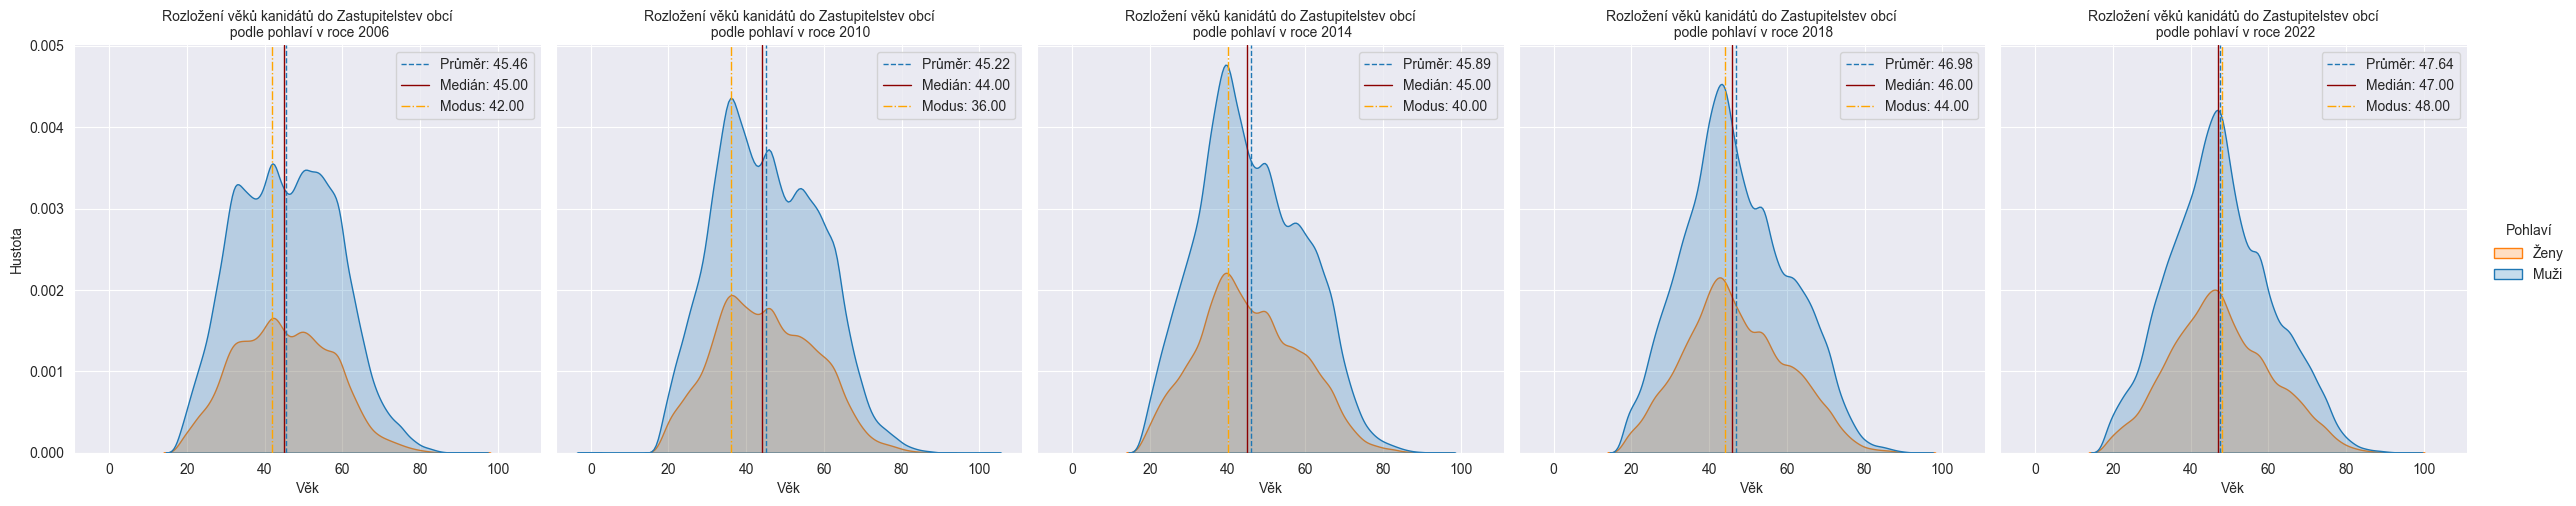

In [8]:
g = sns.displot(
    data=zaso_clean_all_years, x="VEK", hue="pohlavi", kind="kde", fill=True, legend=False, col="year"
)
g.set_titles("Rozložení věků kanidátů do Zastupitelstev obcí\n podle pohlaví v roce {col_name}")
g.set(xlabel="Věk", ylabel="Hustota")
g.add_legend(labels=["Ženy", "Muži"], title="Pohlaví", loc="center right")


years_avgs = {}
for i, year in enumerate(zaso_years):
    years_avgs[i] = [zaso_clean_all_years.query(f"year == {year}")["VEK"].mean(),
                     zaso_clean_all_years.query(f"year == {year}")["VEK"].median(),
                     zaso_clean_all_years.query(f"year == {year}")["VEK"].mode().iat[0]]

axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.axvline(years_avgs[i][0], ls="--", lw=1.0, label=f"""Průměr: {years_avgs[i][0]:.2f}""")
    ax.axvline(years_avgs[i][1], color="darkred", lw=1.0, label=f"""Medián: {years_avgs[i][1]:.2f}""")
    ax.axvline(years_avgs[i][2], ls="-.", color = "orange", lw=1.0, label=f"""Modus: {years_avgs[i][2]:.2f}""")
    ax.legend(loc=0)

In [9]:
zaso_clean_all_years["POVOLANI"].value_counts()[:100].index.tolist()

['důchodce',
 'podnikatel',
 'OSVČ',
 'technik',
 'dělník',
 'živnostník',
 'řidič',
 'důchodkyně',
 'učitelka',
 'účetní',
 'student',
 'státní zaměstnanec',
 'soukromý podnikatel',
 'zdravotní sestra',
 'dělnice',
 'prodavačka',
 'podnikatelka',
 'ekonom',
 'učitel',
 'obchodní zástupce',
 'zámečník',
 'úřednice',
 'mateřská dovolená',
 'administrativní pracovnice',
 'manažer',
 'starosta',
 'invalidní důchodce',
 'projektant',
 'automechanik',
 'lékař',
 'studentka',
 'zedník',
 'elektrikář',
 'skladník',
 'truhlář',
 'soukromý zemědělec',
 'jednatel společnosti',
 'ekonomka',
 'stavební technik',
 'hasič',
 'zaměstnanec',
 'starosta obce',
 'právník',
 'kuchařka',
 'lékařka',
 'úředník',
 'konstruktér',
 'údržbář',
 'programátor',
 'pedagog',
 'v domácnosti',
 'stavbyvedoucí',
 'traktorista',
 'servisní technik',
 'učitelka MŠ',
 'elektromechanik',
 'učitelka ZŠ',
 'projektový manažer',
 'strojník',
 'policista',
 'technolog',
 'mechanik',
 'obchodní manažer',
 'vedoucí výroby',
 '

Důchod: důchod…
Podnikání: podnikatel, majitel,
Živnostníci: OSVČ, živnostník
Dělníci: technik, dělník, řidič, zámečník, automechanik, zedník, elektrikář, skladník, truhlář, kuchař, údržbář, strojník, mechanik, instalatér, seřizovač, svářeč,  výroba, operátor,
Finance: účetní, ekonom, finanční
Studenti: student
Státní zaměstnance: učitel, hasič, policista, úřednice, administrativní, pedagog, sociální, vychovatel, mistr, referent
Medicina: zdravotní, lékař, chirurg
Soukromý sektor: prodavač, zaměstnanec, asistent
Paid leave: dovolené, v domácnosti, nezaměstnaná
Manažeři: manažer, obchodní zástupce, projektant, jednatel, vedoucí, ředitel
Politika: starosta
Zemědělství: zemědělec, traktorista
Právo: právník, advokát,
Technicky-stavební obor: projektant, konstruktér, elektro-mechanik, technolog, inženýr, architekt,
IT: programátor,